In [3]:
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt

In [4]:
tissues=["APE","BM","COL","ILE","LIV","LN","PANC","PROS","STO"]
PRTs = []
for tissue in tissues:
    PRTs.append(ad.read_h5ad(f'PRT_{tissue}.h5ad'))
PRT = ad.concat(PRTs, uns_merge='first')

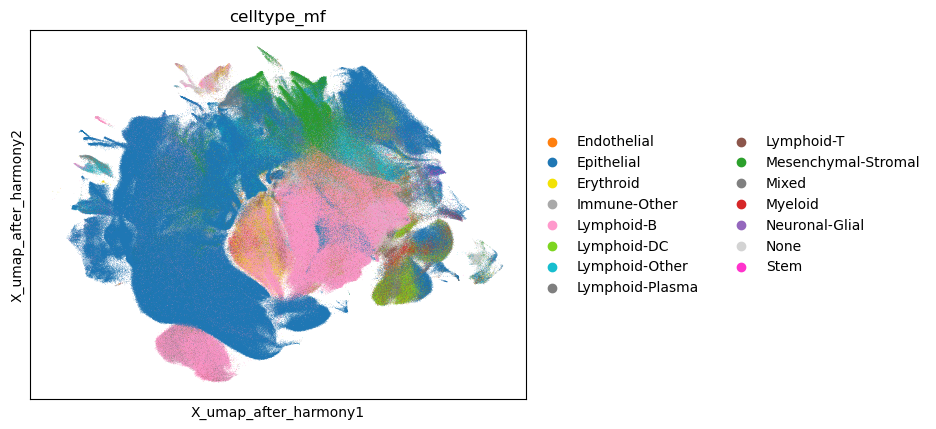

In [11]:
palette = ['#ff7f0e', #endo
           '#1f77b4', #epi
           '#f2e205', #ery
           'darkgray', #immune
           '#ff99cc', #B
           '#7DD520', #DC
           '#17becf', #Other
           '#7f7f7f', #Plasma
           '#8c564b', #T
           '#2ca02c', #Mesen
           'gray', #mixed
           '#d62728', #Myeloid
           '#9467bd', #Neuro
           'lightgray', #None
           '#ff33cc', #Stem
]

sc.pl.embedding(PRT, basis='X_umap_after_harmony', color='celltype_mf', size=0.4, palette=palette)

In [6]:
sc.pp.scale(PRT)

/mnt/scratch1/miniconda3/envs/rsc-luke/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


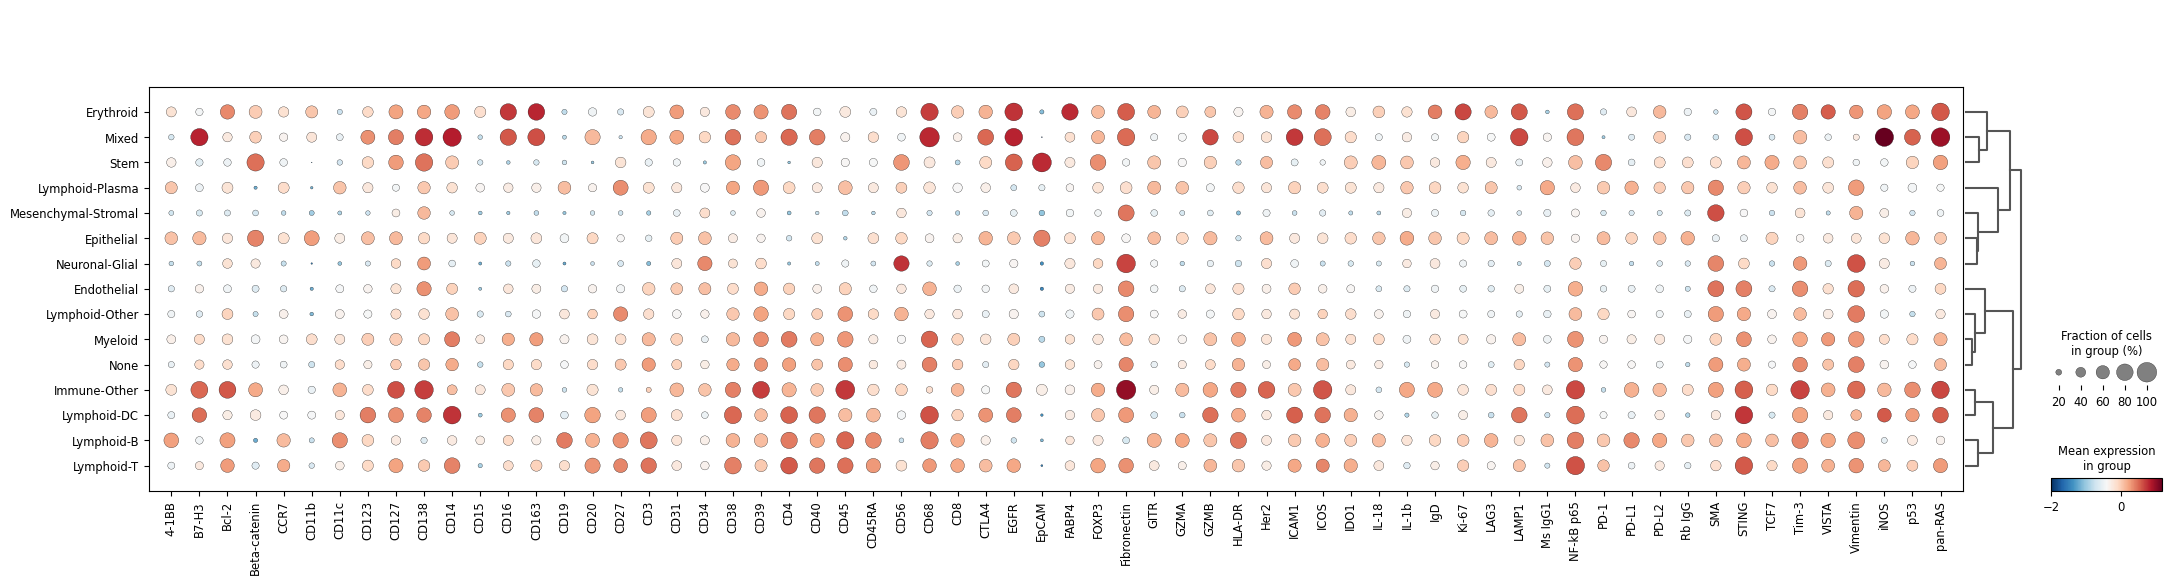

In [7]:
sc.pl.dotplot(PRT, PRT.var_names.to_list(), groupby='celltype_mf', dendrogram=True, log=True, cmap='RdBu_r')

/tmp/ipykernel_1587344/2522726382.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = gene_df.groupby(obs_column).mean()


Heatmap data shape: (15, 64)


/mnt/scratch1/miniconda3/envs/rsc-luke/lib/python3.10/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


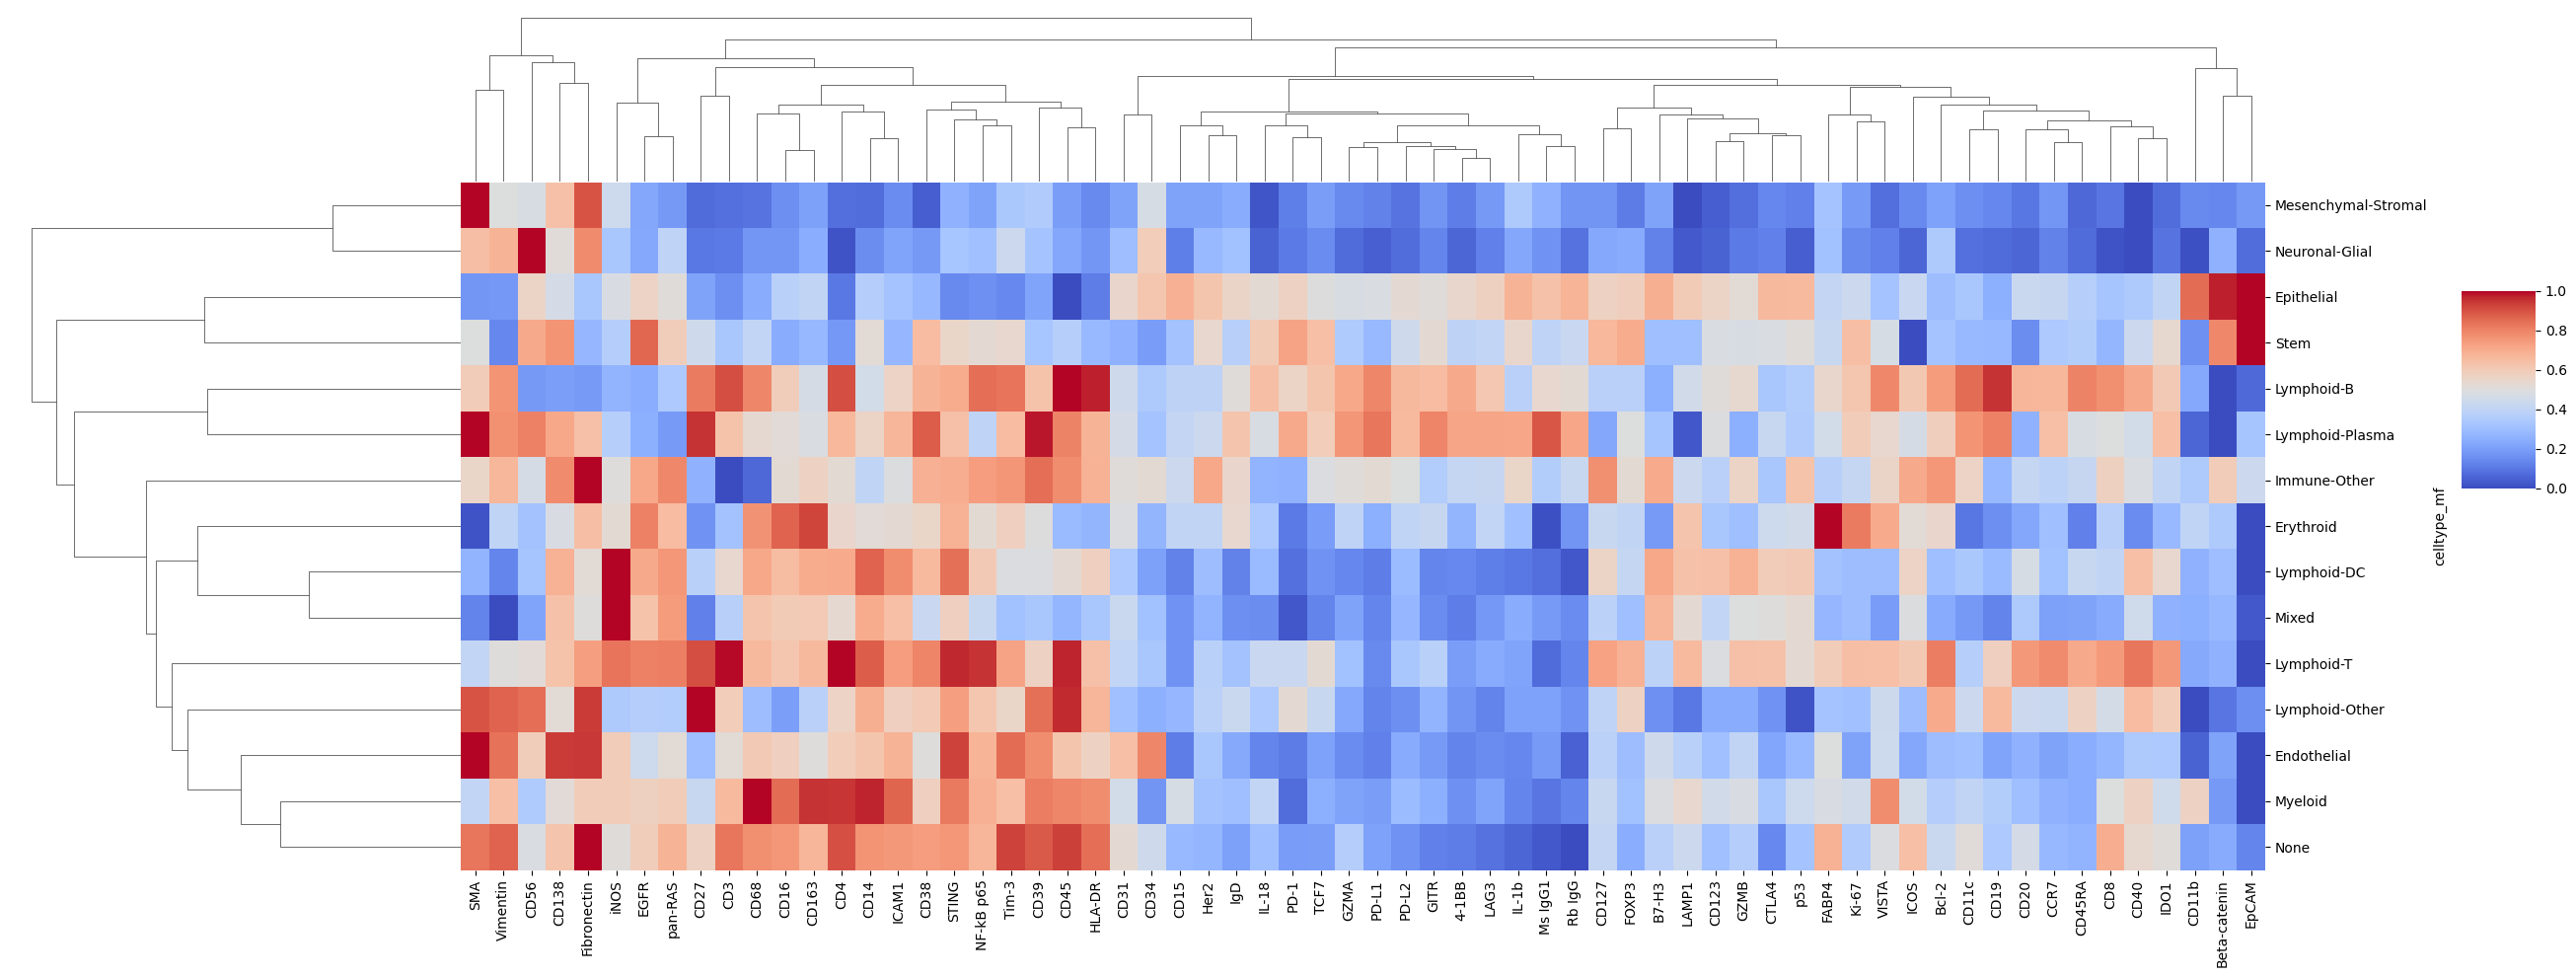

In [9]:
import seaborn as sns

obs_column = 'celltype_mf'
gene_data = PRT.X
adata = PRT
genes = adata.var_names.tolist()

# Convert gene data to DataFrame, handling different formats (dense, sparse, CuPy)
if isinstance(gene_data, np.ndarray):  
    gene_df = pd.DataFrame(gene_data, index=adata.obs_names, columns=genes)
elif hasattr(gene_data, "get"):  # If it's a CuPy array, convert to NumPy
    gene_df = pd.DataFrame(gene_data.get(), index=adata.obs_names, columns=genes)
else:  # Assume it's a sparse matrix
    gene_df = pd.DataFrame(gene_data.toarray(), index=adata.obs_names, columns=genes)

# Add cluster/observation metadata
gene_df[obs_column] = adata.obs[obs_column]
# Compute mean gene expression per cluster
heatmap_data = gene_df.groupby(obs_column).mean()
heatmap_data = heatmap_data[genes]

# Print data shape for debugging
print(f"Heatmap data shape: {heatmap_data.shape}")

# Plot the clustermap with improved settings
g = sns.clustermap(
    heatmap_data, 
    cmap="coolwarm", 
    standard_scale=0,  # Normalize per row (cluster)
    figsize=(25, 10),  # Adjust figure size
    xticklabels=True, 
    yticklabels=True, 
    col_cluster=True,  # Adjust dendrogram proportions
    cbar_pos=(1, 0.5, 0.03, 0.2),  # Adjust color bar position
    square=True  # Ensure cells remain square
)

# Save to PDF
g.savefig("heatmap.pdf", format="pdf")
plt.show()